In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import numpy as np
from scipy.special import j1
from scipy.ndimage import center_of_mass as com
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pickle

## I. Load experimental data

In [18]:
DATA_FILE = './data_correction_Zernike4'

In [19]:
with open(DATA_FILE, 'rb') as file:
    data = pickle.load(file)

In [20]:
last_image = data['evol_coeff_imgs'][-1]
resolution = last_image.shape

## II. Generate theoretical best PSF

### II.1 Find the center of the main lobe of the experimental PSF

We compute the center of mass of the main lobe for the optimized image. 
It will serve as an initial guess for fitting the PSF with an Airy disk.

In [21]:
image_for_com = last_image/np.max(last_image)
image_for_com[image_for_com< 0.5] = 0
center = com(image_for_com) 


### II.2 Compute of the ideal PSF

#### Useful functions

In [22]:
def normalize(A):
    '''
    Normalize a 2D intensity pattern
    - 1. Make sure we remove the background, we do not want to integrate 
    over noise or offset of the camera
    - 2. Divide by the norm of the image
    '''
    PIXEL_THRESHOLD = 5
    A = A / np.max(A) * 255
    A = A* (A > PIXEL_THRESHOLD)
    return A/np.linalg.norm(A)

def get_airy(var_a, var_f, var_cx, var_cy):
    """
    Calculates the intensity distribution of an Airy disk pattern.
    Parameters are defined with respect t
    
    Args:
        var_a (float): Deviation factor for the radius of the Airy disk pattern.
        var_f (float): Deviation factor for the focal length of the Airy disk pattern.
        var_cx (float): Deviation factor for the x-coordinate of the center of the Airy disk pattern.
        var_cy (float): Deviation factor for the y-coordinate of the center of the Airy disk pattern.

    Returns:
        numpy.ndarray: 2D array representing the intensity distribution of the Airy disk pattern.
    """

    a, f, cx, cy = a0*var_a, f0*var_f, cx0*var_cx, cy0*var_cy
    X = X0-cx/resolution[0]
    Y = Y0-cy/resolution[0]
    R = np.sqrt(X**2+Y**2)

    Rpos = R>eps
    R0 = ~Rpos 


    U = np.pi*a * (R/np.sqrt(R**2+f**2))
    I = np.ones_like(U)
        # I =  (2*j1(U[Rpos])/U[Rpos])**2 + 1.*R0
    I[Rpos] = (2*j1(U[Rpos])/U[Rpos])**2

    I = normalize(I)
    return I
    

# Error function: mean square error of the difference of intensity distributions
error = lambda A,B : np.mean(np.abs(A-B)**2)/(np.mean(np.abs(A)**2)*np.mean(np.abs(B)**2))



#### Fit the optimized pattern to an Airy disk

In [23]:
# Generate the grid
x0 = np.arange(0, resolution[0])
x0 = x0/resolution[0]
y0 = np.arange(0, resolution[1])
y0 = y0/resolution[0]
X0,Y0 = np.meshgrid(x0,y0)

# Stagnation parameter
eps = np.finfo(float).eps*100

# Initial guess parameters
a0 = 40
f0 = 1.
cy0, cx0 = center
vec0 = [a0, f0, cx0, cy0]

In [24]:
# Normalize the experimental last image
Iexp = normalize(data['evol_coeff_imgs'][-1])


def f_opt(x):
    '''
    Return the error between the image and the ideal Airy pattern
    for a given set of parameters.
    '''
    a, f, cy, cx = x
    I = get_airy(a, f, cx, cy)
    cost = error(I, Iexp)
    return cost

# use scipy optimize to find the best fit
res = minimize(f_opt, [1.]*4)
a, f, cy, cx = [g*f for g,f in zip(res.x, vec0)]

# Best airy disk
If = get_airy(*res.x)
If = normalize(If)

# compute the Strehl ratio
get_strehl = lambda A,B: np.max(A)/np.max(B)

last_strehl = get_strehl(Iexp, If)

## III. Show optimized result

III.1. Compare optimized PSF and ideal one

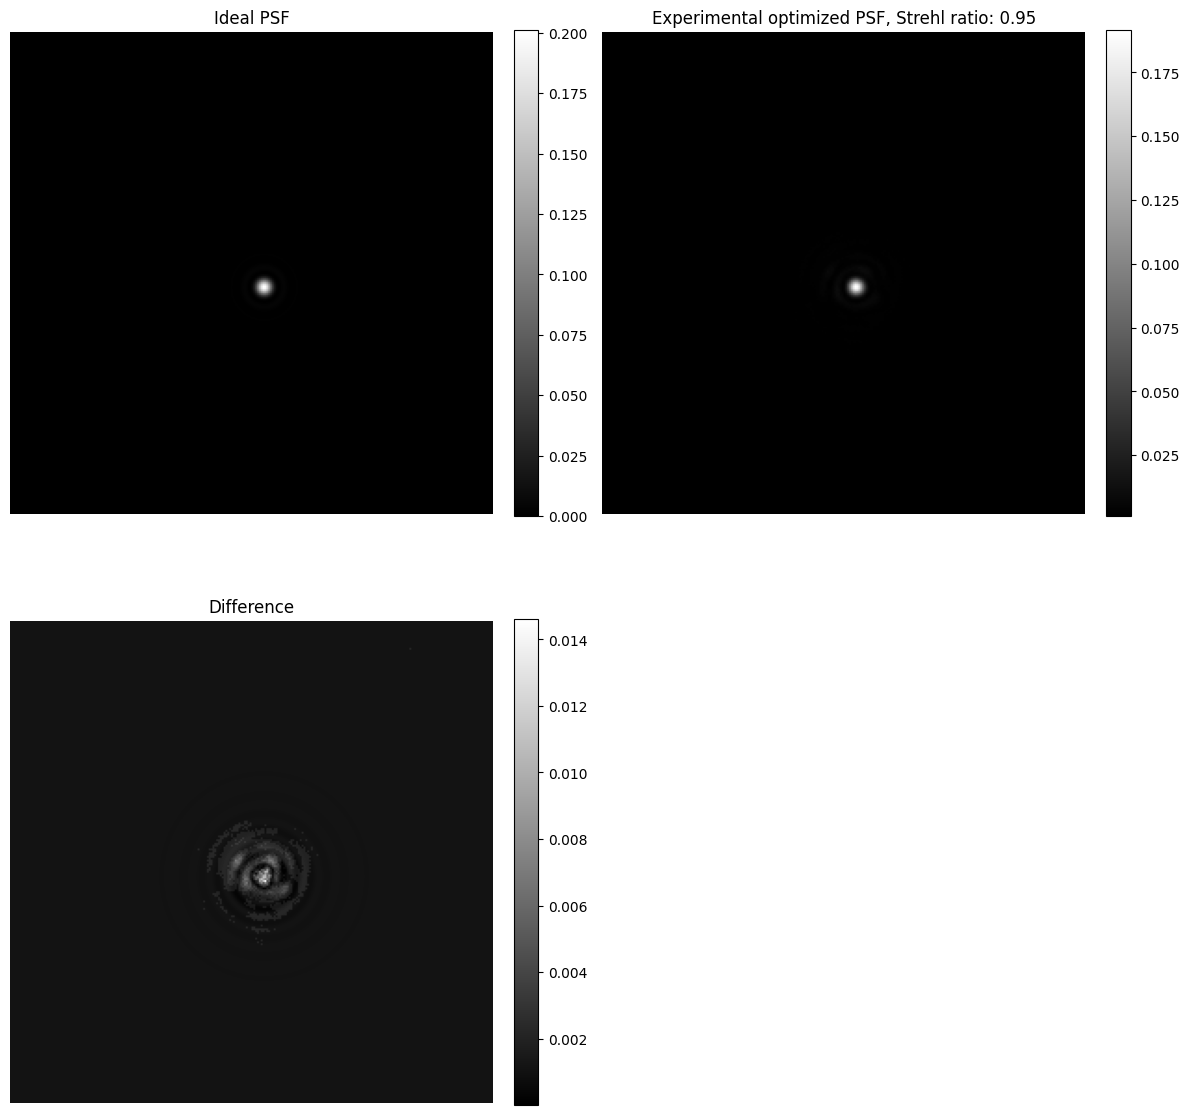

In [25]:
def show_im(A, title = None):
    im = plt.imshow(A, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.gcf().colorbar(im, fraction=0.046, pad=0.04)

plt.figure(figsize=(12,12))
plt.subplot(221)
show_im(If,  title = 'Ideal PSF')
plt.subplot(222)
show_im(Iexp, title = f'Experimental optimized PSF, Strehl ratio: {last_strehl:.2f}')
plt.subplot(223)
show_im(np.abs(If-Iexp), title = 'Difference')
plt.tight_layout()




### III.2 Show cross-section of the experimental and ideal PSFs

Text(0.5, 0.98, 'Cross section of the PSF')

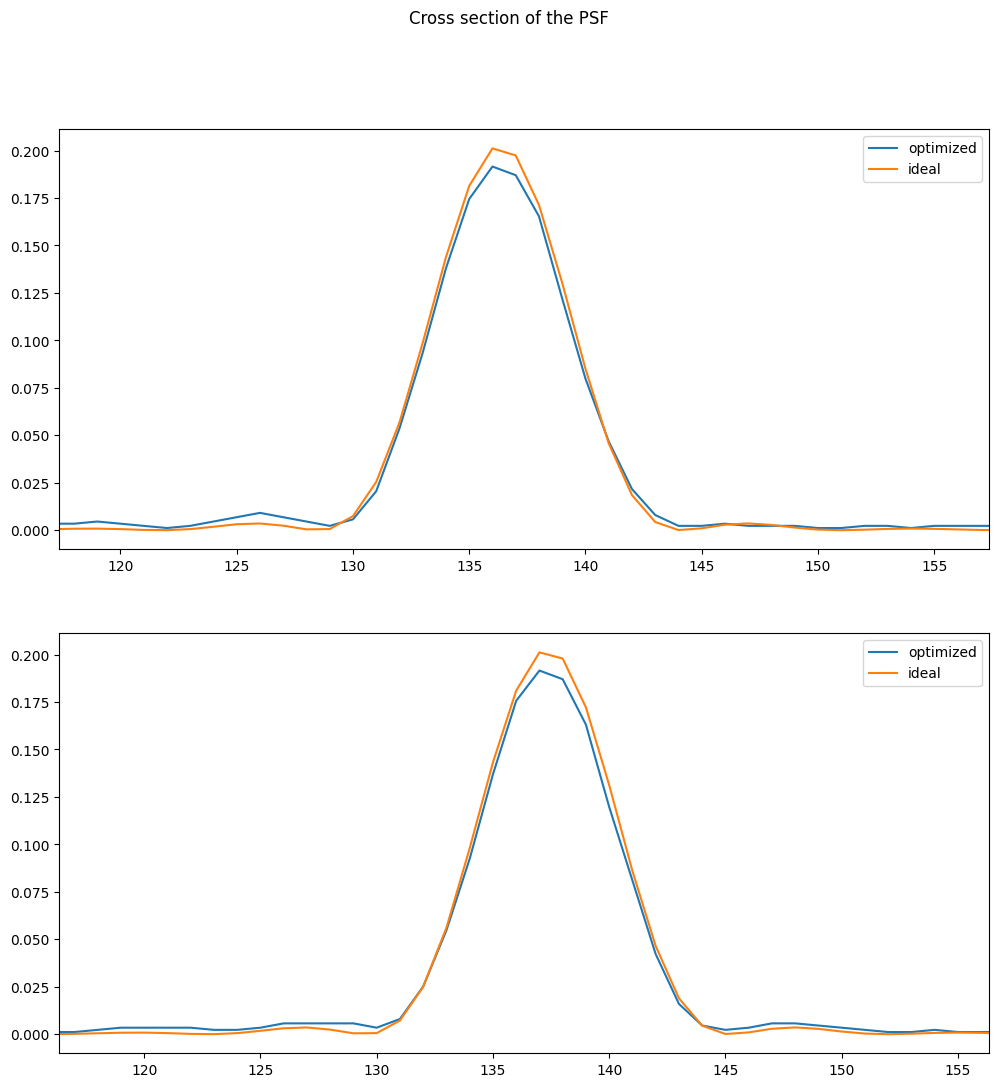

In [26]:
plt.figure(figsize=(12,12))
plt.subplot(211)
c = cx  
plt.plot(Iexp[int(c),:], label = 'optimized')
plt.plot(If[int(c),:], label = 'ideal')
plt.xlim([c-20,c+20])
plt.legend()
plt.subplot(212)
c = cy
plt.plot(Iexp[:,int(c)], label = 'optimized')
plt.plot(If[:,int(c)], label = 'ideal')
plt.xlim([c-20,c+20])
plt.legend()
plt.suptitle('Cross section of the PSF')


### III. 3 Show optimal phase mask

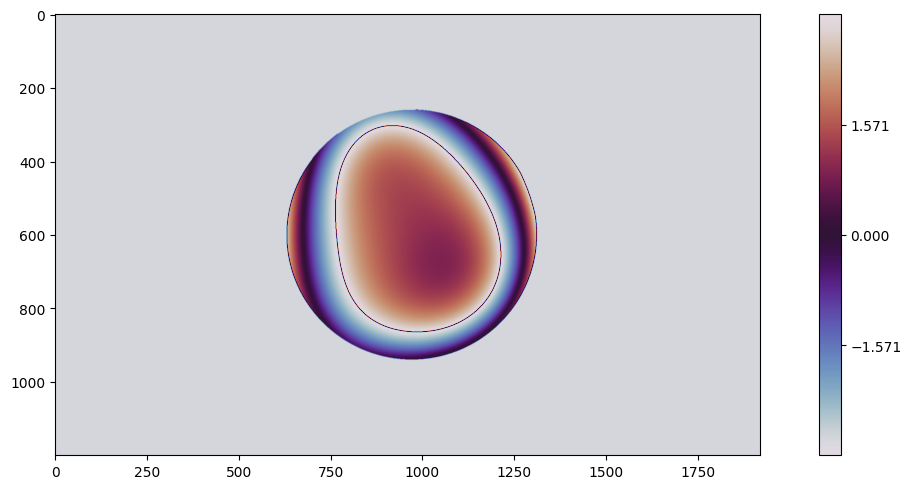

In [27]:
shift_angle = lambda A, phi: np.angle(np.exp(1j*(np.angle(A)+phi)))
phase_corr = data['correction_complex_mask']
plt.figure(figsize = (12,5))
plt.imshow(shift_angle(phase_corr, np.pi*1.07), cmap = 'twilight', interpolation = 'gaussian')
# change ticks and labels of colorbar
plt.colorbar(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
# plt.clim(-np.pi+0.01, np.pi-0.01)
plt.tight_layout()
plt.savefig('phase_mask.svg', dpi=300)

### III. 4. Show the Zernike coefficients for the optimized mask

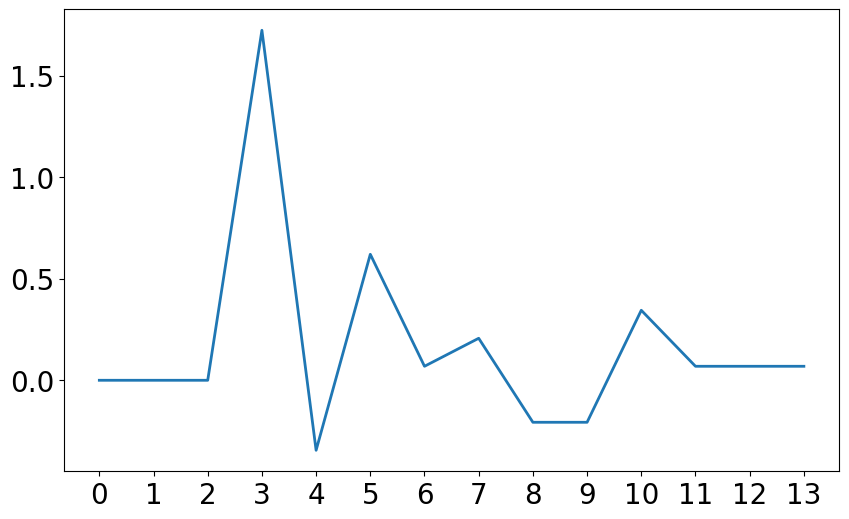

In [28]:
z_coeff = data['zernike_coefficients']

plt.figure(figsize = (10,6))
plt.plot(z_coeff, linewidth = 2)
plt.xticks(ticks=np.arange(len(z_coeff)), fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('zernike_coeff.svg', dpi=300, bbox_inches='tight')

## IV. Show evolution during optimization

### IV.1. Compute Strehl ratio at each step of the optimization

In [29]:
strehl_evol = [get_strehl(normalize(I), normalize(If)) for I in data['evol_coeff_imgs']]

### IV.2. Show results

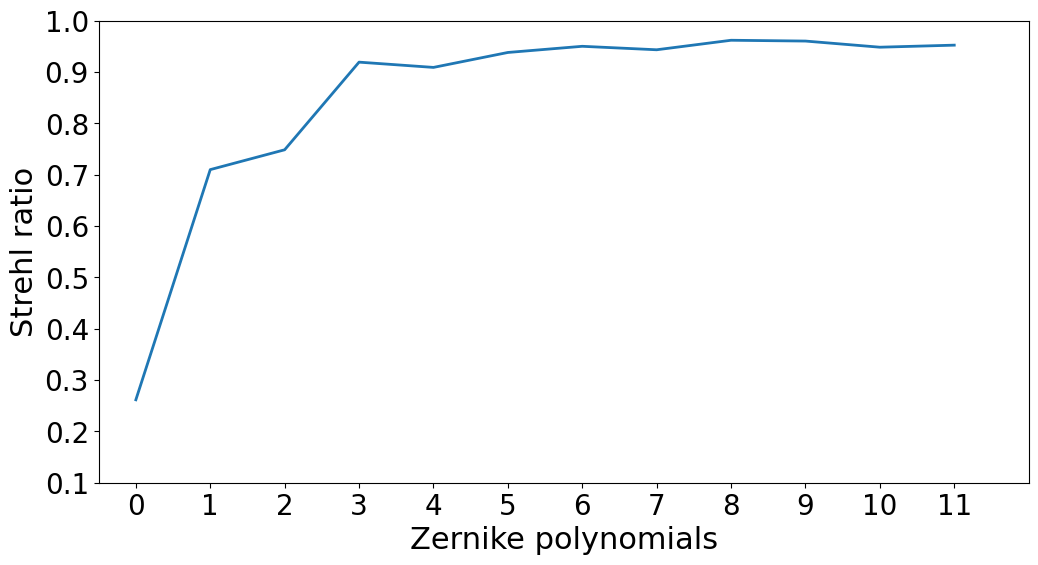

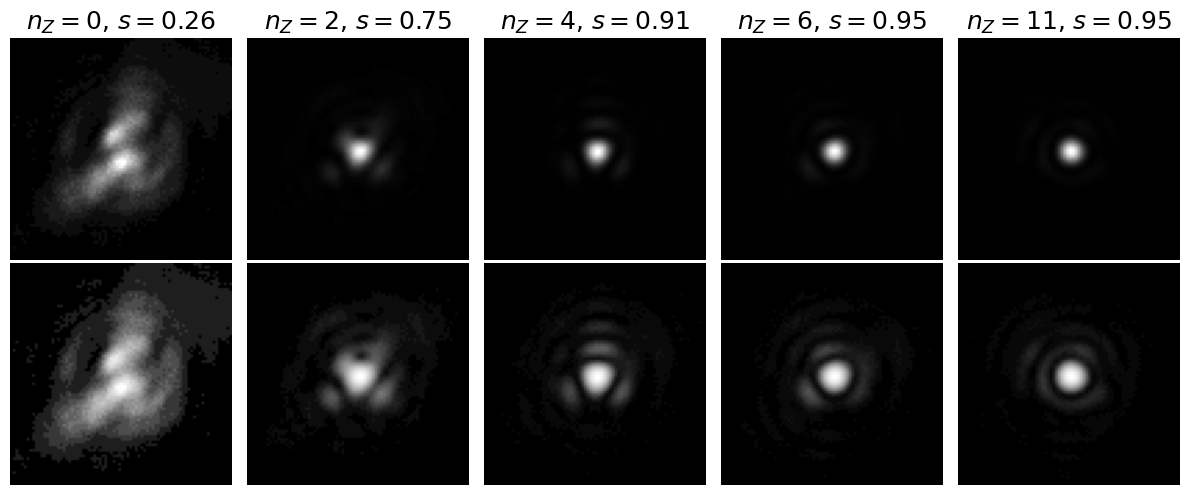

In [30]:


plt.figure(figsize = (12,6))
plt.plot(strehl_evol, linewidth = 2)
plt.xlabel(r'Zernike polynomials', fontsize = 22)
plt.ylabel(r'Strehl ratio', fontsize = 22)
plt.ylim([0.1, 1.])
plt.xlim([-0.5, len(strehl_evol)])
plt.xticks(ticks= np.arange(len(strehl_evol)), fontsize=20)
plt.yticks(fontsize=20)
# draw horizonta line 
# plt.hlines(0.9, -0.5, len(strehl_evol)-1, linestyle='--', color='k')
plt.savefig('strehl_evol.svg', dpi=300, bbox_inches='tight')


to_show = [0,2,4,6,11]


w = 80
plt.figure(figsize = (12,5))
for i, ind in enumerate(to_show):
    I = normalize(data['evol_coeff_imgs'][ind])
    A = I[int(cx-w//2):int(cx+w//2), int(cy-w//2):int(cy+w//2)]
    # A = np.sqrt(A)
    B  =np.log(A+1e-2)
    plt.subplot(2,len(to_show),i+1)
    plt.imshow(A, cmap='gray')
    plt.title('$n_Z=$'+f'${ind}$, $s={strehl_evol[ind]:.2f}$', fontsize = 18)
    plt.axis('off')

    plt.subplot(2,len(to_show),len(to_show)+i+1)
    plt.imshow(B, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.savefig('psf_evol.svg', dpi=300)

### IV.3 Generate video

In [31]:
# Initialize the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
res = data['evol_coeff_imgs'].shape[1:]
out = cv2.VideoWriter('output.mp4', fourcc, 2., res, isColor=False)

# Write each frame
for frame in data['evol_coeff_imgs']:
    out.write(cv2.merge([frame, frame, frame]))

# Release the video writer
out.release()

In [32]:
crop_value = 20
def do_crop(A, crop_value):
    return A[...,crop_value:-crop_value,crop_value:-crop_value]

crop = 100
n_images = len(data['evol_coeff_imgs'])

array = np.array(data['evol_coeff_imgs'])
## use scipy to zoom on images
from scipy.ndimage import zoom
array = zoom(array, zoom = (1,3,3), order = 1)

frame_max = np.max(array, axis = (-1,-2))
max_tot = frame_max.max()
array = np.uint8(array.astype(float)*255/max_tot )
array = do_crop(array, crop_value)
array

array_log = np.log(array+1e-2)
array_log= np.uint8(array_log.astype(float)*255/np.max(array_log) )
# array_log = do_crop(array_log, crop_value)

frames = np.concatenate((array,array_log), axis = 1)

res = frames.shape[1:]
print(res)

# initialize video writer
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 1
video_filename = 'movie_evol_n_zernike_psf.avi'
out = cv2.VideoWriter(video_filename, fourcc, fps, res)

font = cv2.FONT_HERSHEY_SIMPLEX
font_size = 3
font_color = (255, 255, 255)  # White
font_thickness = 2

delta_y = 100
delta_x = 200

# Coordinates of the bottom-left corner of the text
text_position = (delta_x, delta_y)

# new frame after each addition of water
# Write each frame
for ind_z, strehl, frame in zip(range(n_images), strehl_evol, frames):
    gray_3c = cv2.merge([frame.transpose()]*3)
    colored_frame = cv2.applyColorMap(gray_3c, cv2.COLORMAP_JET)
    cv2.putText(colored_frame, rf'Nz={ind_z}', text_position, font, font_size, font_color, font_thickness)
    cv2.putText(colored_frame, rf's={strehl:.2f}', (res[0]//2+delta_x, delta_y), font, font_size, font_color, font_thickness)
    cv2.putText(colored_frame, 'linear scale', (delta_x, res[1]-delta_y), font, 2, font_color, font_thickness)
    cv2.putText(colored_frame, 'log scale', (res[0]//2+delta_x, res[1]-delta_y), font, 2, font_color, font_thickness)
    out.write(colored_frame)
        

# close out the video writer
out.release()

(1480, 740)
